In [1]:
from sys import path
path.append('../')
import estimation as est
import LinearModels as lm
import SampleSelection_post as ssm

import numpy as np
import pandas as pd
from numpy import linalg as la
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import optimize

%load_ext autoreload
%autoreload 2

# Introduction

In this dataset, you will use a part of the dataset from
Conley and Decarolis (2016). The data contains bids for public procurement
auctions for roadwork in Italy. In 2008, the Turing Court of Justice
ruled that in 276 auctions for roadwork held between 2000 and 2003, the
auctions had been rigged by 8 cartels made up of 95 firms. It turns out
that the auction format, called the Average Bid Auction (ABA), is
particularly susceptible to collusion between bidders. However, for a
cartel to be successful at one particular auction, it is essential that
many cartel participants be present at that auction. When enough of the
cartel is present at the auction, they are able to strategically
manipulate the average bid.

The implication is that the bids made by a given firm depends on the
identity of other firms showing up at the auction. This contradicts a
perfectly competitive outcome, in which firms should not condition their
bidding on the specific identities of their opponents. Thus, one simple
tests of perfect competition might be whether the bid posted by a firm
depends on how closely related the firm is to the opposing firms in that
auction. If firms are randomly distributed across auctions, we can just
regress the bid, $y_{i1}$, on how closely related the firm is to other
firms in the auction, controlling for proxies for the "size" of the firm
(labor, capital, etc.).

The issue is that firms are not randomly allocated to auctions. Instead,
firms are more likely to participate in auctions that are close to their
headquarters. Hence, the distance to the site of the roadwork being
auctioned may act as our **exclusion restriction** under the following
assumptions:

1.  Firms prefer to win projects close to their home location,

2.  Conditional on winning an auction, distance does not matter for the
    marginal cost (i.e. it is a fixed, sunk cost to go to the site).

Of course, 2 may be criticized. The figure below shows the distribution of
distances from all eligible firms to the sites, split by whether the
firm chose to participate or not. This clearly shows that distance
affects whether a firm chooses to participate.

<img src="../smaller_pic.png" alt="Drawing" style="width: 500px;"/>


# Data

After deleting rows with missing observations, the data covers 891
auctions where a large number of firms considered whether or not to make
a bid. There are $N=91,845$ observations where a firm was eligible to
make a bid, and if it did, we observe the variable $y_{i1}=1$ (called
`participation` in the data). Otherwise, $y_{i1}=0$.

The submitted bid, which is only available for the 37,699 observations
where $y_{i1}=1$, is the variable `bid_discount`, which we denote
$y_{i2}$. It indicates the percentage discount relative to the
reservation price chosen by the auctioneer, which a firm is willing to
conduct the project for. The variable is missing (i.e. equal to `NaN`)
whenever $y_{i1}=0$ -- that is, when the given firm did not submit a bid
in the auction.

The exclusion restriction to be used is $z_{i}=$ `logmiles_fiwo`, which
is the log of (one plus) the miles between the address of the firm
(rather, the centroid of the zip code of the firm) and the site of the
project under procurement. The remaining variables are described below:

| **Variable** | **Description** |
| ---- | ---- |
| backlog_lagged  | a measure of the number of projects currently in progress at the firm. 	|
| logcapital | log of the total capital (accounting variable).	|
| labor | measure of employed labor.	|
| count_linktot_out  | A measure of closeness to other firms.	|
| auction_type | =0 if the auction is an Average Bid Auction,	|
|				|=1 for First Price Sealed Bid.	|
| participated  | whether the firm submitted a bid (yi1).	|
| logmiles_fiwo | distance from the firm to the location of the project under auction.	|
| firm_type_unlim_liab  | Firm is not limited liability.	|
| auction_id | ID variable for the auction.	|
| region | Dummy for the region in which the project is to take place. 	|
| year | Calendar year.	|

# The Heckman 2-step

Suppose our dataset consists of $N$ observations of
$\{x_{i1},y_{i1}\}_{i=1}^{N}$, where $y_{i1}\in\{0,1\}$ denotes
"selection," and $x_{i1}\in\mathbb{R}^{K_{1}}$. For the "selected
sample", $\mathcal{S}=\{i|y_{i1}=1\}$, we furthermore observe data
$\{x_{i2},y_{i2}\}_{i\in\mathcal{S}}$, where $y_{i2}\in\mathbb{R}$ and
$x_{i2}\in\mathbb{R}^{K_{2}}$. Note that we also observe $x_{i1}$ for
the selected sample. The model then is

We assume the following model, 

$$
\begin{aligned}
y_{i1} & = \mathbf{1}\{x_{i1}'\beta_{1}+\varepsilon_{i1}\},\quad\varepsilon|x_{i1}\sim\mathcal{N}(0,1), & (1) \\
y_{i2} & = x_{i2}'\beta_{2}+\varepsilon_{i2},\quad\text{E}(\varepsilon_{i2}|\varepsilon_{i1})=\gamma\varepsilon_{i1}. & (2)
\end{aligned}
$$

The Heckman sample selection model has two steps:

**Step 1 (Selection equation):** Estimate $\hat{\beta}_{1}$ by running a Probit
    regression of $y_{i1}$ on $x_{i1}$ using the full sample,
    $i\in\{1,...,N\}$. Compute
    $\hat{\lambda}_{i}\equiv\frac{\phi(x_{i1}'\hat{\beta}_{1})}{\Phi(x_{i1}'\hat{\beta}_{1})}$,
    where $\phi$ and $\Phi$ are the pdf and cdf of the standard normal
    distribution, respectively.

**Step 2 (Outcome equation):** Run a linear regression of $y_{i2}$ on $x_{i2}$ and
    $\hat{\lambda}_{i}$, obtaining estimate $\hat{\beta}_{2}$ and
    $\hat{\gamma}$ respectively.

We refer to any variables, $z_{i}$, in $x_{i2}$ that are not in $x_{i1}$
as *exclusion restrictions*. These are variables that satisfy the
following:

**Assumption 1 (Exclusion):** $z_{i}$ affects selection ($y_{i1}$) but not the outcome ($y_{i2}$),

**Assumption 2 (Relevance):** $z_{i}$ is a strong predictor of selection, i.e. it's coefficient in $\beta_{2}$ is statistically significant.

In [2]:
# Since we are doing some more advanced data choices, we start by using pandas.
# This makes the whole process easier.
data = pd.read_csv('conley_decariolis.csv', sep=',')
data['t'] = data['year'] - min(data['year'])

In [3]:
# Create labels for variables
ylbl = 'participated'
exclusion_restriction = 'logmiles_fiwo'
xlbl = ['backlog_lagged',  'logcapital', 'count_linktot_in', 'labor', 'firm_type_unlim_liab', 't']

# We want to check for missings and remove them, but only for variables that we are interested in.
# We therefore gather all the labels into one "check_missing" label.
check_missing = xlbl.copy()
check_missing.append(ylbl)
check_missing.append(exclusion_restriction)

In [4]:
# Keep only auctions that are of type "average bid", which is the 0 category.
data = data[data['auction_type'] == 0.0]

# Remove missings only present in the variables denoted by check_missing labels.
data.dropna(inplace=True, subset=check_missing)

In [5]:
# Allocate data to their own variables.
# y1 is whether a firm participated in the auction or not.
y1 = data[ylbl].to_numpy().reshape(-1, 1)

# Exclusion restriction is distance from company to job.
z = data[exclusion_restriction].to_numpy().reshape(-1, 1)

x = data[xlbl].to_numpy()
cnst = np.ones(y1.size).reshape(-1, 1)
x = np.hstack((x, cnst))

# x1 (and y1) is to be used with equation (1).
x1 = np.hstack((z, x))

# y2 denotes how high a bid was.
# We keep in x2 only those who bid on the acution (as one participate in a bid, y1==1, but refrain from bidding, y2==nan).
# x2 and y2 is to be used with equation (2).
y2 = data['bid_discount'][data['participated'] == 1].to_numpy().reshape(-1, 1)
x2 = x[data['participated'] == 1]

# Add constant label to x
xlbl.append('const')
# add exclusion restriction label x1
x1lbl=xlbl.copy()
x1lbl.append(exclusion_restriction)

### Question 1:
Estimate the outcome equation (2) (using OLS and variables x2 and y2), without controlling for selection into the sample (since we have not calculated the inverse mills ratio yet). Print it out in a nice table, and focus on the effect of `count_linktot_in` as a proxy for the closeness of firm relationships. Does 

In [6]:
# Finally estimate the model and print data.
ols_result = lm.estimate(y2, x2)
lm.print_table(
    ('Bid discount', xlbl), 
    ols_result, 
    title="Outcome w/o controlling for selection.", 
    floatfmt='.4f'
)

Outcome w/o controlling for selection.
Dependent variable: Bid discount

                         Beta      Se    t-values
--------------------  -------  ------  ----------
backlog_lagged        -0.0484  0.1756     -0.2755
logcapital            -0.1399  0.0212     -6.6077
count_linktot_in       0.0132  0.0018      7.2640
labor                  0.0041  0.0009      4.7850
firm_type_unlim_liab  -1.0389  0.1173     -8.8547
t                      0.6685  0.0425     15.7440
const                 12.7181  0.0725    175.3357
R² = 0.010
σ² = 27.444


## Question 2: 
Replicate the histogram above, showing that there might be a selection bias. You do this by using the `Data` frame, and plot the histograms of `logmiles_fiwo` both for `participated == 0` and `participated == 1`. See if you are able to plot both histograms in the same plot, with a transparent overlap.

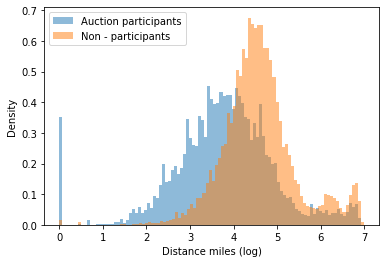

In [7]:
# Plot histograms
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['logmiles_fiwo'][data['participated'] == 1], bins=100, alpha=0.5, density=True)
ax.hist(data['logmiles_fiwo'][data['participated'] == 0], bins=100, alpha=0.5, density=True) 
ax.legend(['Auction participants', 'Non - participants'])
ax.set_xlabel('Distance miles (log)')
ax.set_ylabel('Density') ;

## Question 3
Compute the Heckit 2-step estimator using `logmiles_fiwo` as the exclusion restriction.

1. First estimate eq. (1) using y1 and x1.
2. Use the results from the first step estimation to calculate the inverse Mills ratio (which should be a $n \times 1$ vector). In order to use this in the second step estimation, you need to keep only the rows from the inverse Mills ratio that participate in an auction (this can be done using y1 in boolean indexing).
3. Include the inverse Mills ratio in x2 (if you include it as the first column, x2 will work with the rest of the code).
4. Re-estimate eq. (2) using y2 and the new x2. Is the inverse Mills ratio significant? What about `count_linktot_in`, has this become insignificant when controlling for selection bias?

In [8]:
first_step = est.estimate(
    ssm.q, ssm.starting_values(y1, x1), y1, x1
)
est.print_table(x1lbl, first_step, title='First step results')

Optimization terminated successfully.
         Current function value: 0.513605
         Iterations: 34
         Function evaluations: 342
         Gradient evaluations: 38
Optimizer succeded after 34 iter. (342 func. evals.). Final criterion:   0.5136.
First step results


,theta,se,t
backlog_lagged,-0.1242,0.0050,-24.7226
logcapital,0.0548,0.0436,1.2558
count_linktot_in,0.0520,0.0035,14.7093
labor,0.0689,0.0004,170.9495
firm_type_unlim_liab,-0.0009,0.0001,-6.5566
t,0.0993,0.0210,4.7407
const,0.0167,0.0083,1.9999
logmiles_fiwo,-0.3488,0.0268,-13.0210


In [9]:
# Mills ratio
xb = x1@first_step['theta']
_lambda = norm.pdf(xb)/norm.cdf(xb)

# Keep only for those we observe participated
_lambda = _lambda[y1.flatten() == 1]

In [10]:
x2 = np.hstack((_lambda.reshape(-1, 1), x2))

In [11]:
# We also have to update label
xlbl.insert(0, 'Mills Ratio')

In [12]:
# Second step
second_step = lm.estimate(y2, x2)
lm.print_table(
    (ylbl, xlbl), second_step, 
    title="Outcome controlling for selection", floatfmt='.4f'
)

Outcome controlling for selection
Dependent variable: participated

                         Beta      Se    t-values
--------------------  -------  ------  ----------
Mills Ratio            4.0299  0.1526     26.4059
backlog_lagged         0.0992  0.1763      0.5625
logcapital            -0.0019  0.0215     -0.0871
count_linktot_in       0.1399  0.0049     28.7297
labor                  0.0016  0.0009      1.8663
firm_type_unlim_liab  -0.8248  0.1152     -7.1610
t                      0.6832  0.0420     16.2735
const                  7.6211  0.2039     37.3759
R² = 0.026
σ² = 27.007


## Comparing results:

In [13]:
data = {"beta w. sel.": second_step.get('b_hat').flatten(), 
        "beta w/o. sel.": np.append(None,ols_result.get('b_hat').flatten()), # Appending a None element to account for the Mills Ratio
        "t-values w. sel":  second_step.get('t_values').flatten(),
        "t-values w/o. sel": np.append(None,ols_result.get('t_values').flatten()) # Appending a None element to account for the Mills Ratio
       }
pd.DataFrame(data=data, index = xlbl)

,beta w. sel.,beta w/o. sel.,t-values w. sel,t-values w/o. sel
Mills Ratio,4.029877,None,26.405941,None
backlog_lagged,0.099158,-0.048371,0.562500,-0.275452
logcapital,-0.001875,-0.139889,-0.087067,-6.607749
count_linktot_in,0.139882,0.013238,28.729693,7.263993
labor,0.001592,0.004093,1.866348,4.78504
firm_type_unlim_liab,-0.824802,-1.038934,-7.161040,-8.854658
t,0.683213,0.66852,16.273483,15.744012
const,7.621122,12.718103,37.375889,175.335711
